In [ ]:
%pip install -q keras-tuner --upgrade
%pip install -q yfinance

In [ ]:
%pip install scikit-learn --upgrade

In [ ]:
import time
import datetime
import random
import json
import os
import sys

import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
#from tabulate import tabulate
from IPython.display import display

import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, TimeDistributed, LeakyReLU, Conv1D, MaxPooling1D, Conv1DTranspose, Flatten, concatenate, Reshape, Cropping1D
from tensorflow.keras.models import  Sequential, Model, load_model, save_model
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import keras_tuner
from keras.regularizers import L1, L2, L1L2
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from keras.utils import to_categorical, timeseries_dataset_from_array

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import sklearn.metrics as skm

## Data Loading

In [ ]:
# @title Labelling
import time

import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from tqdm import tqdm

def fixed_time_horizon(close, horizon=5, threshold=.1):
    """
    Labels data according to returns over a horizon:
        r_t+h,t = p_t+h /p_t - 1

        y_i = 1 if r_t+h,t > threshold
        y_i = -1 if r_t+h,t < -threshold
        y_i = 0 if -threshold < r_t+h,t < threshold
    """
    horizon_returns = (close.shift(-horizon) / close - 1).dropna()

    labels = pd.Series(0,index=horizon_returns.index)
    labels += horizon_returns > threshold
    labels -= horizon_returns < -threshold

    return labels

def binary_fixed_time_horizon(close, horizon=5, threshold=.5):
    """
    Labels data according to returns over a horizon:
        r_t+h,t = p_t+h /p_t - 1

        y_i = 1 if r_t+h,t > threshold
        y_i = 0 if r_t+h,t < threshold
    """
    horizon_returns = (close.shift(-horizon) / close - 1).dropna()

    labels = pd.Series(0,index=horizon_returns.index)
    labels += horizon_returns > threshold

    return labels

def dynamic_threshold(close, horizon=5, span=10):
    """
    Calculates the exponentially weighted moving standard deviation of returns, with:
        r_t+h,t = p_t+h /p_t - 1

        y_i = 1 if r_t+h,t > ema_std_t
        y_i = -1 if r_t+h,t < -ema_std_t
        y_i = 0 if -ema_std_t < r_t+h,t < ema_std_t
    """
    horizon_returns = close.shift(-horizon) / close - 1

    daily_returns = close / close.shift(1) - 1
    previous_day_std = daily_returns.shift(1).rolling(window=span).std()
    ema_std = previous_day_std.ewm(span=span).mean().dropna()

    df = pd.concat([horizon_returns,ema_std], axis=1, keys=['horizon_returns', 'ema_std']).dropna()
    labels = pd.Series(0,index=df.index)
    labels += df['horizon_returns'] > df['ema_std']
    labels -= df['horizon_returns'] < -df['ema_std']

    return labels

def binary_dynamic_threshold(close, horizon=5, span=10):
    """
    Calculates the exponentially weighted moving standard deviation of returns, with:
        r_t+h,t = p_t+h /p_t - 1

        y_i = 1 if r_t+h,t > ema_std_t
        y_i = 0 if r_t+h,t <= -ema_std_t
    """
    horizon_returns = close.shift(-horizon) / close - 1

    daily_returns = close / close.shift(1) - 1
    previous_day_std = daily_returns.shift(1).rolling(window=span).std()
    ema_std = previous_day_std.ewm(span=span).mean().dropna()

    df = pd.concat([horizon_returns,ema_std], axis=1, keys=['horizon_returns', 'ema_std']).dropna()
    labels = pd.Series(0,index=df.index)
    labels += df['horizon_returns'] > df['ema_std']

    return labels


def get_labels(data, tickers, method="dynamic_threshold", horizon=4, span=10, threshold=.06):
    """
    Produces a label dataframe with labels per ticker <label_{ticker_name}>

    <method>:
        dynamic_threshold
        fixed_time_horizon
        triple_barrier
    """
    data = data.copy()
    labels = pd.DataFrame()


    for ticker in tqdm(tickers):
        close = data[f'close_{ticker}']
        if method == "fixed_time_horizon":
            labels[f'label_{ticker}'] = fixed_time_horizon(close, horizon, threshold)
        elif method == "dynamic_threshold":
            labels[f'label_{ticker}'] = dynamic_threshold(close, horizon, span)
        elif method == "binary_fixed_time_horizon":
            labels[f'label_{ticker}'] = binary_fixed_time_horizon(close, horizon, threshold)
        elif method == "binary_dynamic_threshold":
            labels[f'label_{ticker}'] = binary_dynamic_threshold(close, horizon, span)
        labels = labels.copy()
    return labels


def col_value_counts(df):
    normalized_value_counts = {}
    for column in df.columns:
        counts = df[column].value_counts()
        normalized_counts = counts / counts.sum()
        normalized_value_counts[column] = normalized_counts
    normalized_df = pd.DataFrame(normalized_value_counts)
    return normalized_df

In [ ]:
# @title Dataset loading preparation
def get_last_N_years(data, N):
    '''
    Gets the last N years for a DataFrame with a date index.
    '''
    end_date = data.index.max()
    start_date = end_date - pd.DateOffset(years=N)
    return data[data.index >= start_date]

def get_first_N_years(data, N):
    '''
    Gets the last N years for a DataFrame with a date index.
    '''
    start_date = data.index.min()
    end_date =  start_date + pd.DateOffset(years=N)

    return data[data.index <= end_date]

def get_tickers(data):
    return list({c[len('close_'):] for c in data.columns if c.startswith('close_')})

def get_tickers2(data):
    '''
    Gets tickers for stat2 data (for which get_tickers mistakenly gets diff_{n}_{ticker} as columns).
    '''
    return list({c[len('close_diff_1_'):] for c in data.columns if c.startswith('close_diff_1_')})

def remove_last_N_tickers(data, sorted_tickers, N):
    '''
    Returns all features in data without tickers associated to the last N tickers
    in the list sorted_tickers.
    '''
    data = data.copy()
    cols = [f"_{i}" for i in sorted_tickers[-N:]]
    return data[data.columns[~data.columns.str.contains('|'.join(cols))]]

def col_value_counts(df):
    '''
    Returns the normalized value counts of each colum of df.
    '''
    normalized_value_counts = {}
    for column in df.columns:
        counts = df[column].value_counts()
        normalized_counts = counts / counts.sum()
        normalized_value_counts[column] = normalized_counts
    normalized_df = pd.DataFrame(normalized_value_counts)
    return normalized_df

def get_ticker_data(data, ticker, time_features=False):
    '''
    Returns all columns in data associated to the ticker, plus cyclical time features.
    '''
    ticker_columns = [i for i in data.columns if i.endswith(f'_{ticker}')]
    if time_features:
        time_features = ['day_of_year_sin', 'day_of_year_cos', 'day_of_year_sin', 'day_of_week_cos']
        return data[ticker_columns + time_features]
    return data[ticker_columns]

def get_ticker_datasets(data, labels, tickers, reduced=False, binary_labels=False, one_hot=False, time_features=False):
    '''
    Args:
        data: A DataFrame containing features for each ticker with format {col_name}_{ticker},
        and (optionally) time features with format day_of_{week | year}_{sin | cos}.
        labels: A DataFrame containing columns with labels for each ticker with
        format label_{ticker}
        tickers: A list of stock symbols.
        binary_labels: If labels are NOT binary, they are in range {-1,0,1}. Therefore
        they must be converted to range {0,1,2}.

    Returns:
        ticker_datasets: A dict with the ticker symbols as keys, and (ticker_data, ticker_label) tuples as values,
        ticker_data contains all features associated to the ticker, plus time features
        ticker_label contains labels for the ticker
    '''
    data = data.copy()
    ticker_datasets = dict()

    for ticker in tickers:
        ticker_data = get_ticker_data(data, ticker, time_features)
        if reduced:
            if one_hot:
                ticker_label = to_categorical(labels+(not binary_labels))
            else:
                ticker_label = labels+(not binary_labels)
        else:
            if one_hot:
                ticker_label = to_categorical(labels[f'label_{ticker}'] + (not binary_labels))
            else:
                ticker_label = labels[f'label_{ticker}'] + (not binary_labels)
        ticker_datasets[ticker] = (ticker_data, ticker_label)
    return ticker_datasets

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

def get_only_ohcl_dataset(ticker_datasets, tickers):
    for ticker in tickers:
        cols = [
            f'close_{ticker}',
            f'high_{ticker}',
            f'low_{ticker}',
            f'open_{ticker}',
            f'volume_{ticker}',
            f'close_diff_1_{ticker}',
            f'close_diff_5_{ticker}',
            f'close_diff_20_{ticker}',
            f'close_diff_252_{ticker}',
            f'high_diff_1_{ticker}',
            f'high_diff_5_{ticker}',
            f'high_diff_20_{ticker}',
            f'high_diff_252_{ticker}',
            f'open_diff_1_{ticker}',
            f'open_diff_5_{ticker}',
            f'open_diff_20_{ticker}',
            f'open_diff_252_{ticker}',
            f'low_diff_1_{ticker}',
            f'low_diff_5_{ticker}',
            f'low_diff_20_{ticker}',
            f'low_diff_252_{ticker}',
        ]
        ticker_datasets[ticker] = (ticker_datasets[ticker][0][cols], ticker_datasets[ticker][1])

In [ ]:
# @title Utils (Splits, Testing and Logs)
def get_sequential_split(data, labels=None, time_gap=0, test_size=None, val_size=None):
    '''
    Splits the data for each ticker sequentially into X_train, X_val(optional) and X_test according to test_size and val_size.
    '''
    n = len(data)

    if val_size is not None:
        train_size = 1 - test_size - val_size
        split_point_train = int(n * train_size)
        split_point_val = int(n * (train_size+val_size))
        X_train = data[:split_point_train]
        X_val = data[split_point_train + time_gap:split_point_val]
        X_test = data[split_point_val + time_gap:]

        if labels is not None:
            y_train = labels[:split_point_train]
            y_val = labels[split_point_train + time_gap:split_point_val]
            y_test = labels[split_point_val + time_gap:]
            return X_train, y_train, X_val, y_val, X_test, y_test
        return X_train, X_val, X_test

def get_ticker_split_datasets(ticker_datasets, test_size, val_size, time_gap=0, batch_size=100, window_length=10, stride=1, one_hot=True):
    '''
    Takes a dict <ticker_datasets> with ticker keys, and (ticker_data, ticker_labels) tuples as values.
        - Splits the data for each ticker sequentially into X_train, X_val(optional) and X_test according to test_size and val_size.
        - The splits have a gap of <time_gap> samples between them.
        - Each split is normalized to zero mean and unit variance according to the distribution of X_train.
        - Each split is processed into batches with windows according to <length> and <stride>.

    Returns a tuple of dicts (ticker_train_val_datasets, ticker_test_datasets) or (ticker_train_datasets, ticker_test_datasets)
    '''
    if val_size is not None:
        ticker_train_val_datasets = dict()
        ticker_test_datasets = dict()
        ticker_class_weights = dict()

        for ticker in ticker_datasets:
            ticker_data, ticker_labels = ticker_datasets[ticker]
            ticker_data = ticker_data[:-window_length]
            ticker_labels = ticker_labels[window_length-1:]

            X_train, y_train, X_val, y_val, X_test, y_test = get_sequential_split(ticker_data, labels=ticker_labels, test_size=test_size, val_size=val_size, time_gap=time_gap)

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)

            D_train = timeseries_dataset_from_array(
                X_train,
                y_train,
                window_length,
                sequence_stride=1,
                sampling_rate=1,
                batch_size=batch_size,
                shuffle=True,
                seed=None,
                start_index=None,
                end_index=None,
            )

            D_val = timeseries_dataset_from_array(
                X_val,
                y_val,
                window_length,
                stride,
                sampling_rate=1,
                batch_size=batch_size,
                shuffle=True,
                seed=None,
                start_index=None,
                end_index=None,
            )

            D_test = timeseries_dataset_from_array(
                X_test,
                y_test,
                window_length,
                sequence_stride=1,
                sampling_rate=1,
                batch_size=batch_size,
                shuffle=True,
                seed=None,
                start_index=None,
                end_index=None,
            )

            ticker_train_val_datasets[ticker] = (D_train, D_val)
            ticker_test_datasets[ticker] = D_test

            # class weights
            if one_hot:
                unique_classes = np.unique(np.argmax(y_train, axis=1))
                class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=np.argmax(y_train, axis=1))
            else:
                class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train)

            ticker_class_weights[ticker] = class_weights

        return ticker_train_val_datasets, ticker_test_datasets, ticker_class_weights

def get_split_datasets(ticker_datasets, test_size, val_size=None, time_gap=0, batch_size=100, window_length=10, stride=1, sampling_rate=1, shuffle_buffer=70000, per_ticker_test=False, one_hot=True):
    '''
    Takes a dict <ticker_datasets> with ticker keys, and (ticker_data, ticker_labels) tuples as values.
        - Splits the data for each ticker sequentially into X_train, X_val(optional) and X_test according to test_size and val_size.
        - The splits have a gap of <time_gap> samples between them.
        - Each split is normalized to zero mean and unit variance according to the distribution of X_train.
        - Each split is processed into batches with windows according to <length> and <stride>.
        - Splits are merged for all tickers

    Returns a tuple of (D_train, D_val, D_test) or (D_train, D_test)
    '''
    if val_size is not None:
        D_train = None
        D_val = None
        D_test = None
        all_y_train = np.array([])

        if per_ticker_test:
            D_test = dict()

        for ticker in tqdm(ticker_datasets):
            ticker_data, ticker_labels = ticker_datasets[ticker]
            ticker_data = ticker_data[:-window_length]
            ticker_labels = ticker_labels[window_length-1:]

            X_train, y_train, X_val, y_val, X_test, y_test = get_sequential_split(ticker_data, labels=ticker_labels, test_size=test_size, val_size=val_size, time_gap=time_gap)

            scaler = StandardScaler() # MinMaxScaler() #

            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)

            D_train_ticker = timeseries_dataset_from_array(
                X_train,
                y_train,
                window_length,
                stride,
                sampling_rate=sampling_rate,
                batch_size=None,
                shuffle=False,
                seed=None,
                start_index=None,
                end_index=None,
            )

            D_val_ticker = timeseries_dataset_from_array(
                X_val,
                y_val,
                window_length,
                sequence_stride=1,
                sampling_rate=1,
                batch_size=None,
                shuffle=False,
                seed=None,
                start_index=None,
                end_index=None,
            )

            D_test_ticker = timeseries_dataset_from_array(
                X_test,
                y_test,
                window_length,
                sequence_stride=1,
                sampling_rate=1,
                batch_size=None,
                shuffle=False,
                seed=None,
                start_index=None,
                end_index=None,
            )

            if D_train == None:
                D_train = D_train_ticker
                D_val = D_val_ticker
                if not per_ticker_test:
                    D_test = D_test_ticker
                else:
                    D_test_ticker = D_test_ticker.shuffle(shuffle_buffer)
                    D_test_ticker = D_test_ticker.batch(batch_size)
                    D_test[ticker] = D_test_ticker
            else:
                D_train = D_train.concatenate(D_train_ticker)
                D_val = D_val.concatenate(D_val_ticker)
                if not per_ticker_test:
                    D_test = D_test.concatenate(D_test_ticker)
                else:
                    D_test_ticker = D_test_ticker.shuffle(shuffle_buffer)
                    D_test_ticker = D_test_ticker.batch(batch_size)
                    D_test[ticker] = D_test_ticker

            all_y_train = np.concatenate((all_y_train, y_train.to_numpy()))

        D_train = D_train.shuffle(shuffle_buffer)
        D_train = D_train.batch(batch_size)

        #D_val = D_val.shuffle(shuffle_buffer)
        D_val = D_val.batch(batch_size)

        if (not per_ticker_test):
            #D_test = D_test.shuffle(shuffle_buffer)
            D_test = D_test.batch(batch_size)

        if one_hot:
            unique_classes = np.unique(np.argmax(all_y_train, axis=1))
            class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=np.argmax(all_y_train, axis=1))
        else:
            class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=all_y_train)

        class_weights = {i: w for i, w in enumerate(class_weights)}

        return D_train, D_val, D_test, class_weights

def get_ticker_cv_datasets(ticker_datasets, test_size, train_test_time_gap=0, cv_time_gap=100, batch_size=100, window_length=10, stride=1, n_cv_splits=5):
    '''
    Takes a dict <ticker_datasets> with ticker keys, and (ticker_data, ticker_labels) tuples as values.
        - Splits the data for each ticker sequentially into X_train and X_test according to test_size.
        - The splits have a gap of <time_gap> samples between them.
        - The Test split is normalized to zero mean and unit variance according to the distribution of X_train.
        - The Train split is processed into <n_cv_splits> sequential cross validation datasets with a gap of <cv_time_gap> samples between them.
        - Each cv split is processed into batches with windows according to <length> and <stride>.

    Returns a tuple of dicts (ticker_cv_datasets, ticker_test_datasets) where
    ticker_cv_datasets is a dict with ticker keys, each with a list of (X_train, X_val) tuples as values
    '''
    ticker_cv_datasets = dict()
    ticker_test_datasets = dict()
    for ticker in ticker_datasets:
        ticker_data, ticker_labels = ticker_datasets[ticker]
        X_train, y_train, X_test, y_test = get_sequential_split(ticker_data, labels=ticker_labels, test_size=test_size, time_gap=train_test_time_gap)

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_test = scaler.transform(X_test)

        D_test = TimeseriesGenerator(X_test, y_test, length=window_length, stride=stride, batch_size=batch_size)
        ticker_test_datasets[ticker] = D_test

        val_size = (1 - test_size) * val_size

        tscv = TimeSeriesSplit(gap=cv_time_gap, n_splits=n_cv_splits)
        ticker_train_val_datasets = []
        for train_index, test_index in tscv.split(X_train):
            X_train_, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index,:]
            y_train_, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
            scaler = StandardScaler()
            X_train_ = scaler.fit_transform(X_train_)
            X_val = scaler.transform(X_val)

            D_train = TimeseriesGenerator(X_train_, y_train_, length=window_length, stride=stride, batch_size=batch_size)
            D_val = TimeseriesGenerator(X_val, y_val, length=window_length, stride=stride, batch_size=batch_size)
            ticker_train_val_datasets.append((D_train, D_val))
        ticker_cv_datasets[ticker] = ticker_train_val_datasets

    return ticker_cv_datasets, ticker_test_datasets

def get_average_class_weights(ticker_datasets):
    class_weights_list = []

    for ticker in ticker_datasets:
        ticker_data, ticker_labels = ticker_datasets[ticker]
        _,y_train,_,_,_,_ = get_sequential_split(ticker_data, labels=ticker_labels, test_size=.15, val_size=.15, time_gap=100)

        unique_classes = np.unique(np.argmax(y_train, axis=1))
        class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=np.argmax(y_train, axis=1))

        class_weight_dict = {i: w for i, w in enumerate(class_weights)}
        class_weights_list.append(class_weight_dict)

    average_class_weights = {}
    for class_idx in range(len(unique_classes)):
        class_weight_sum = sum(weights[class_idx] for weights in class_weights_list)
        average_weight = class_weight_sum / len(tickers)
        average_class_weights[class_idx] = average_weight

    return average_class_weights

def get_ticker_class_weights(ticker_datasets, one_hot=False):
    ticker_class_weights = dict()
    for ticker in ticker_datasets:
        ticker_data, ticker_labels = ticker_datasets[ticker]
        _,y_train,_,_,_,_ = get_sequential_split(ticker_data, labels=ticker_labels, test_size=.15, val_size=.15, time_gap=100)

        if one_hot:
            unique_classes = np.unique(np.argmax(y_train, axis=1))
            class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=np.argmax(y_train, axis=1))
        else:
            class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train)

        class_weight_dict = {i: w for i, w in enumerate(class_weights)}
        ticker_class_weights[ticker] = class_weight_dict
    return ticker_class_weights

def get_ticker_test_results(D_test, tickers, verbose=True, autoencoder=False):
    ticker_test_results = dict()

    for ticker in tqdm(tickers):
        #print(f"****************** Evaluating {ticker} ******************")
        if autoencoder:
            f = lambda x: [x[0]]
        else:
            f = lambda x: [x[0],x[1],x[2][0],x[3],x[4]]
        res = model.evaluate(D_test[ticker], verbose=0)
        ticker_test_results[ticker] = f(res)
        #print("**********************************************************\n\n")

    if autoencoder:
        ticker_test_results = pd.DataFrame.from_dict(ticker_test_results, orient='index', columns=['loss'])
    else:
        ticker_test_results = pd.DataFrame.from_dict(ticker_test_results, orient='index', columns=['loss', 'accuracy', 'f1_score', 'precision', 'recall'])

    if verbose and not autoencoder:
        print("\nBest results:")
        display(ticker_test_results[ticker_test_results['f1_score']>.54])

    return ticker_test_results

def plot_train_history(train_loss, val_loss, train_acc=None, val_acc=None, train_f1=None,
                       val_f1=None, train_precision=None, val_precision=None, train_recall=None,
                       val_recall=None, path=None, show=True, lang='Spanish'):
    plt.figure(figsize=(10, 4))
    plt.subplot(2, 3, 1)
    if (lang=='Spanish'):
        plt.plot(range(1, len(train_loss) + 1), train_loss, label='Entrenamiento')
        plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validación')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
    else:
        plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
        plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
    plt.legend()

    if train_acc is not None:
        plt.subplot(2, 3, 2)
        if (lang=='Spanish'):
            plt.plot(range(1, len(train_acc) + 1), train_acc, label='Entrenamiento')
            plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validación')
            plt.xlabel('Época')
            plt.ylabel('Exactitud')
        else:
            plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
            plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
        #plt.legend()

    if train_f1 is not None:
        plt.subplot(2, 3, 3)
        if (lang=='Spanish'):
            plt.plot(range(1, len(train_f1) + 1), train_f1, label='Entrenamiento')
            plt.plot(range(1, len(val_f1) + 1), val_f1, label='Validación')
            plt.xlabel('Época')
            plt.ylabel('Valor-F1')
        else:
            plt.plot(range(1, len(train_f1) + 1), train_f1, label='Training f1-score')
            plt.plot(range(1, len(val_f1) + 1), val_f1, label='Validation f1-score')
            plt.xlabel('Epochs')
            plt.ylabel('f1-score')
        # plt.legend()
        plt.tight_layout()

    if train_precision is not None:
        plt.subplot(2, 3, 4)
        if (lang=='Spanish'):
            plt.plot(range(1, len(train_precision) + 1), train_precision, label='Entrenamiento')
            plt.plot(range(1, len(val_precision) + 1), val_precision, label='Validación')
            plt.xlabel('Época')
            plt.ylabel('Precisión')
        else:
            plt.plot(range(1, len(train_precision) + 1), train_precision, label='Training precision')
            plt.plot(range(1, len(val_precision) + 1), val_precision, label='Validation precision')
            plt.xlabel('Epochs')
            plt.ylabel('Precision')
        plt.legend()
        plt.tight_layout()

    if train_recall is not None:
        plt.subplot(2, 3, 5)
        if (lang=='Spanish'):
            plt.plot(range(1, len(train_recall) + 1), train_recall, label='Entrenamiento')
            plt.plot(range(1, len(val_recall) + 1), val_recall, label='Validación')
            plt.xlabel('Época')
            plt.ylabel('Exhaustividad')
        else:
            plt.plot(range(1, len(train_recall) + 1), train_recall, label='Training recall')
            plt.plot(range(1, len(val_recall) + 1), val_recall, label='Validation recall')
            plt.xlabel('Epochs')
            plt.ylabel('Recall')
        plt.legend()
        plt.tight_layout()

    if path is not None:
        plt.savefig(path, format='svg')
    if show:
        plt.show()
    else:
        plt.close()

def write_train_log(model, model_name, path='/content/drive/MyDrive/model_train_logs', binary_classes=False, autoencoder=False, ticker_test_results=None):
    '''
    Uses the existing values in parameter and training history variables, including:
        parameters: num_stocks, random_stocks, rounds, epochs, patience, balance_weights, load_prev_weights, batch_size, window_length, stride, num_features, dropout, l1_reg, l2_reg, learning_rate, threshold
        training history: train_loss, val_loss, train_acc, val_acc, train_f1, val_f1
    If there are missing variables, the process is aborted.

    Saves the following files to the specified path:
        model_description.txt: Contains model architecture and parameters
        train_history.json: Contains the training history over all epochs and rounds
    '''

    try:
        if autoencoder:
            model_params = {
                'epochs':epochs,
                'patience':patience,
                'load_prev_weights':load_prev_weights,
                'num_features':num_features,
                'batch_size':batch_size,
                'window_length':window_length,
                'stride':stride,
                'sampling_rate':sampling_rate,
                'shuffle_buffer':shuffle_buffer,
                'dropout':dropout,
                'l1_reg':l1_reg,
                'l2_reg':l2_reg,
                'learning_rate':learning_rate,
            }
        else:
            model_params = {
                #'num_stocks':num_stocks,
                #'random_stocks':random_stocks,
                #'rounds':rounds,
                'dataset_name':dataset_name,
                'epochs':epochs,
                'patience':patience,
                'balance_weights':balance_weights,
                'load_prev_weights':load_prev_weights,
                'encoder':encoder is not None,
                'autoencoder_name':autoencoder_name,
                'tune_encoder':tune_encoder,
                'num_features':num_features,
                'batch_size':batch_size,
                'window_length':window_length,
                'stride':stride,
                'sampling_rate':sampling_rate,
                'shuffle_buffer':shuffle_buffer,
                'dropout':dropout,
                'l1_reg':l1_reg,
                'l2_reg':l2_reg,
                'learning_rate':learning_rate,
                'threshold':threshold,
            }
    except:
        print('Error when writting log: Missing model parameters!')
        return

    try:
        if autoencoder:
            train_history = {
                'train_loss':train_loss,
                'val_loss':val_loss,
            }
        else:
            train_history = {
                'train_loss':train_loss,
                'val_loss':val_loss,
                'train_acc':train_acc,
                'val_acc':val_acc,
                'train_f1':train_f1,
                'val_f1':val_f1,
                'train_precision':train_precision,
                'val_precision':val_precision,
                'train_recall':train_recall,
                'val_recall':val_recall,
            }
    except:
        print('Error when writting log: Missing training history!')
        return

    if not autoencoder:
        if binary_classes:
            train_history['train_f1'] = [float(i[0]) for i in train_history['train_f1']]
            train_history['val_f1'] = [float(i[0]) for i in train_history['val_f1']]
        else:
            train_history['train_f1'] = [(float(i[0]),float(i[1]),float(i[2])) for i in train_history['train_f1']]
            train_history['val_f1'] = [(float(i[0]),float(i[1]),float(i[2])) for i in train_history['val_f1']]

    params_string = ''.join([f'\n\t{key} = {value}' for key,value in model_params.items()])
    model._name = model_name + params_string
    params_hash = hash(params_string)
    params_hash += sys.maxsize + 1
    path += f'/{model_name}_{params_hash}'

    if not os.path.exists(path):
        os.makedirs(path)

    plot_train_history(path=f'{path}/train_history.svg', show=False, **train_history)

    with open(f'{path}/model_description.txt', 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))

    with open(f'{path}/train_history.json', 'w') as f:
        json.dump(train_history, f, indent=4)

    model.save(f'{path}/{model_name}_{params_hash}.keras')

    if ticker_test_results is not None:
        ticker_test_results.to_parquet(f'{path}/ticker_test_results.parquet', compression='snappy')

    print(f'Saved model, description, and log at {path}')

In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/data/yahoo_snp500_updated-stat3-30_years')
data2 = pd.read_parquet('/content/drive/MyDrive/data/yahoo_snp500_updated-stat2-30_years')
# data = get_first_N_years(data, 3)
tickers = get_tickers2(data)

In [ ]:
method = 'binary_fixed_time_horizon'
horizon = 2
span = 10
threshold = 0.005
labels = get_labels(data2, tickers, method=method, horizon=horizon, span=span, threshold=threshold)

d = {'binary_fixed_time_horizon':'bfth', 'binary_dynamic_threshold':'bdt', 'fixed_time_horizon':'fth', 'dynamic_threshold':'dt'}

data = data.join(labels).dropna()
dataset_name = f'yahoo_snp500_updated-stat2-30_years-individual-{d[method]}-h_{horizon}-{"s" if d[method] in {"bdt", "dt"} else "t"}_{span if d[method] in {"bdt", "dt"} else str(threshold)[2:]}'

col_value_counts(labels).mean(axis=1)

100%|██████████| 300/300 [00:01<00:00, 154.97it/s]


0    0.580103
1    0.419897
dtype: float64

In [ ]:
# data files have names with format: yahoo_snp500-{ta | stat | stat2}-{N}_years-{individual | b(alanced)}-{dt | fth | bfth}-h_{horizon}-{s_{span} | t_{threshold}}.parquet
#dataset_name = 'yahoo_snp500_updated-stat2-30_years-individual-bfth-h_2-t_005'
#data = pd.read_parquet(f'/content/drive/MyDrive/data/{dataset_name}.parquet')
# data = remove_last_N_tickers(data, sorted_tickers, 235)
# data = get_first_N_years(data, 15)

binary_classes = True
one_hot = not binary_classes
time_features = False
num_features = 184 # 91 # 215 #

tickers = get_tickers2(data)

labels = data[[i for i in data.columns if 'label_' in i]]
data = data.drop(columns=labels)

ticker_datasets = get_ticker_datasets(data, labels, tickers, binary_labels=binary_classes,
                                      one_hot=one_hot, reduced=False, time_features=time_features)

# data = None

In [ ]:
batch_size = 1024
window_length = 256
stride = 15
sampling_rate = 1
shuffle_buffer = 6000

D_train, D_val, D_test, class_weights = get_split_datasets(ticker_datasets, test_size=0.20, val_size=0.15,
                                           time_gap=250, batch_size=batch_size, window_length=window_length,
                                           stride=stride, sampling_rate=sampling_rate, shuffle_buffer=shuffle_buffer,
                                           per_ticker_test=True, one_hot=one_hot)

# ticker_train_val_sets, ticker_test_sets, ticker_class_weights = get_ticker_split_datasets(ticker_datasets, test_size=0.20, val_size=0.15, time_gap=250, batch_size=batch_size, window_length=window_length, stride=stride, one_hot=one_hot)

100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


## Main Models

In [ ]:
def build_model(hp):
    dropout_lstm = hp.Choice('dropout_lstm', [0., 0.01, 0.05, 0.1, 0.2])
    dropout = hp.Choice('dropout', [0., 0.01, 0.05, 0.1])
    l1_reg = hp.Choice('l1_reg', [0., 0.00001, 0.0001, 0.0005, 0.001])
    l2_reg = hp.Choice('l2_reg', [0., 0.00001, 0.0001, 0.0005, 0.001])

    l1_reg_lstm = hp.Choice('l1_reg_lstm', [0., 0.00001, 0.0001, 0.0005, 0.001])
    l2_reg_lstm = hp.Choice('l2_reg_lstm', [0., 0.00001, 0.0001, 0.0005, 0.001])
    units = hp.Choice('units', [32, 64, 128, 256, 384, 512])
    units1 = hp.Choice('units2', [64, 128, 256, 384, 512])
    units2 = hp.Choice('units3', [64, 128])
    activation = hp.Choice('activation', ['relu', 'leaky_relu'])

    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])

    #horizon = hp.Choice('horizon', [1,2,5,15,30])
    #t = hp.Choice('t', list(np.arange(0.005, 0.1, 0.005)))

    #labels = get_labels(data2, tickers, method="binary_fixed_time_horizon", horizon=horizon, threshold=t)
    #df = data2.copy()
    #df = df.join(labels).dropna()

    #ticker_datasets = get_ticker_datasets(df, labels, tickers, binary_labels=binary_classes,
    #                                  one_hot=one_hot, reduced=False, time_features=time_features)

    #D_train, D_val, D_test, class_weights = get_split_datasets(ticker_datasets, test_size=0.20, val_size=0.15,
    #                                       time_gap=250, batch_size=batch_size, window_length=window_length,
    #                                       stride=stride, sampling_rate=sampling_rate, shuffle_buffer=shuffle_buffer,
    #                                       per_ticker_test=True, one_hot=one_hot)

    # encoder = None

    tune_encoder =  hp.Choice('tune_encoder', [False, True])

    autoencoder_name = 'autoencoder-stat3-prov-conv1d_4364845329785447431'
    autoencoder = load_model(f'/content/drive/MyDrive/final_models/stat3-prov/{autoencoder_name}/{autoencoder_name}.keras')

    encoder_input = autoencoder.input
    encoder = autoencoder.get_layer('encoded').output
    encoder = Model(encoder_input, encoder, name='encoder')

    input = Input(shape=(window_length, num_features), batch_size=batch_size, name='input')
    input_shape = (batch_size, window_length, num_features)

    if encoder is not None:
        input = encoder_input
        encoder.trainable = tune_encoder
        model = encoder(input, training=tune_encoder)
    else:
        model = input

    model = TimeDistributed(Dense(units, activation=activation, kernel_regularizer=L1L2(l1_reg_lstm, l2_reg_lstm)))(model)
    model = Dropout(dropout_lstm)(model)

    model = TimeDistributed(Dense(units1, activation=activation, kernel_regularizer=L1L2(l1_reg_lstm, l2_reg_lstm)))(model)
    model = Dropout(dropout_lstm)(model)

    model = TimeDistributed(Dense(units2, activation=activation, kernel_regularizer=L1L2(l1_reg_lstm, l2_reg_lstm)))(model)
    model = Dropout(dropout_lstm)(model)

    model = Flatten()(model)

    model = Dense(64, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)

    model = Dense(32, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)

    model = Dense(5, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)

    model = Dense(1, activation='sigmoid', name='output')(model)

    model = Model(input, model)

    custom_optimizer = Adam(learning_rate=learning_rate, weight_decay=None)

    threshold = 0.5

    accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=threshold)
    f1_score = tf.keras.metrics.F1Score(name='f1_score', threshold=threshold)
    precision = tf.keras.metrics.Precision(name='precision', thresholds=threshold)
    recall = tf.keras.metrics.Recall(name='recall', thresholds=threshold)

    model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=[accuracy, f1_score, precision, recall])

    return model

tuner = keras_tuner.BayesianOptimization (# keras_tuner.RandomSearch(
    build_model,
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=10,
    overwrite=True,
    directory="",
    project_name="tune_hypermodel",
)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=2, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * np.exp(-0.1)
lr_scheduler = LearningRateScheduler(scheduler)

tuner.search(D_train, epochs=5, validation_data=D_val, class_weight=class_weights, callbacks=[early_stopping, lr_scheduler])
best_model = tuner.get_best_models()[0]


Trial 10 Complete [00h 03m 16s]
val_f1_score: 0.5683711767196655

Best val_f1_score So Far: 0.573280930519104
Total elapsed time: 00h 30m 28s


In [ ]:
best_model.summary()
tuner.results_summary()
tuner.get_best_hyperparameters()[0].values

In [ ]:
def get_LSTM_model(dropout=0.1, l1_reg=0.0001, l2_reg=0.0001, learning_rate=0.001, verbose=True, window_length=1, num_features=95, threshold=.5, encoder=None, tune_encoder=False, encoder_input=None, binary_classes=False):
    input = Input(shape=(window_length, num_features), batch_size=batch_size, name='input')
    input_shape = (batch_size, window_length, num_features)

    dropout = 0.15
    dropout_lstm = 0.15
    l2_reg_lstm = 0.0002
    l1_reg_lstm = 0.0001
    l1_reg = 0.
    l2_reg = 1e-05
    activation = 'leaky_relu'
    learning_rate = 0.001
    tune_encoder = 0

    if encoder is not None:
        input = encoder_input
        encoder.trainable = tune_encoder
        model = encoder(input, training=tune_encoder)
    else:
        model = input

    model = LSTM(128, input_shape=(window_length, num_features), return_sequences=True, kernel_regularizer=L1L2(l1_reg_lstm, l2_reg_lstm))(model)
    model = Dropout(dropout_lstm)(model)

    model = TimeDistributed(Dense(128, activation=activation, kernel_regularizer=L1L2(l1_reg_lstm, l2_reg_lstm)))(model)

    model = LSTM(64, return_sequences=False, kernel_regularizer=L1L2(l1_reg_lstm, l2_reg_lstm))(model)
    model = Dropout(dropout_lstm)(model)

    model = Dense(64, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)
    model = Dense(32, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)
    model = Dense(5, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)

    if binary_classes:
        model = Dense(1, activation='sigmoid', name='output')(model)
    else:
        model = Dense(3, activation='softmax', name='output')(model)

    model = Model(input, model)

    custom_optimizer = Adam(learning_rate=learning_rate, weight_decay=None)

    accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=threshold)
    f1_score = tf.keras.metrics.F1Score(name='f1_score', threshold=threshold)
    precision = tf.keras.metrics.Precision(name='precision', thresholds=threshold)
    recall = tf.keras.metrics.Recall(name='recall', thresholds=threshold)

    if binary_classes:
        model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=[accuracy, f1_score, precision, recall])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy', f1_score, precision, recall])

    if verbose:
        model.summary()

    return model

def get_conv_model(dropout=0.1, l1_reg=0.0001, l2_reg=0.0001, learning_rate=0.001, verbose=True, window_length=1, num_features=95, threshold=.5, encoder=None, tune_encoder=False, encoder_input=None, binary_classes=False):
    input = Input(shape=(window_length, num_features), batch_size=batch_size, name='input')
    input_shape = (batch_size, window_length, num_features)

    dropout_lstm = 0.01
    dropout = 0.05
    l1_reg = 0.001
    l2_reg = 0.0001
    l1_reg_lstm = 0.001
    l2_reg_lstm = 0.0001
    activation = 'relu'
    learning_rate = 0.0001
    tune_encoder = 0

    if encoder is not None:
        input = encoder_input
        encoder.trainable = tune_encoder
        model = encoder(input, training=tune_encoder)
    else:
        model = input

    model = Conv1D(128, 3, activation='leaky_relu', padding='same', kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)

    model = Conv1D(32, 3, activation='leaky_relu', padding='same', kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)

    model = Flatten()(model)

    model = Dense(64, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)
    model = Dense(32, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)
    model = Dense(5, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)

    if binary_classes:
        model = Dense(1, activation='sigmoid', name='output')(model)
    else:
        model = Dense(3, activation='softmax', name='output')(model)

    model = Model(input, model)

    custom_optimizer = Adam(learning_rate=learning_rate, weight_decay=None)

    accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=threshold)
    f1_score = tf.keras.metrics.F1Score(name='f1_score', threshold=threshold)
    precision = tf.keras.metrics.Precision(name='precision', thresholds=threshold)
    recall = tf.keras.metrics.Recall(name='recall', thresholds=threshold)

    if binary_classes:
        model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=[accuracy, f1_score, precision, recall])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy', f1_score, precision, recall])

    if verbose:
        model.summary()

    return model

# autoencoder mixed models

def get_encoder_LSTM_model(dropout=0.1, l1_reg=0.0001, l2_reg=0.0001, learning_rate=0.001, verbose=True, window_length=1, num_features=95, threshold=.5, encoder=None, tune_encoder=False, encoder_input=None, binary_classes=False):
    input = Input(shape=(window_length, num_features), batch_size=batch_size, name='input')
    input_shape = (batch_size, window_length, num_features)

    dropout_lstm = 0.01
    dropout = 0.05
    l1_reg = 0.001
    l2_reg = 0.0001
    l1_reg_lstm = 0.001
    l2_reg_lstm = 0.0001
    units = 128
    activation = 'relu'
    learning_rate = 0.0001
    tune_encoder = 0

    if encoder is not None:
        input = encoder_input
        encoder.trainable = tune_encoder
        model = encoder(input, training=tune_encoder)
    else:
        model = input

    model = LSTM(units, input_shape=(window_length, num_features), return_sequences=False, kernel_regularizer=L1L2(l1_reg_lstm, l2_reg_lstm))(model)
    model = Dropout(dropout_lstm)(model)

    model = Dense(64, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)
    model = Dense(32, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)
    model = Dense(5, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)

    if binary_classes:
        model = Dense(1, activation='sigmoid', name='output')(model)
    else:
        model = Dense(3, activation='softmax', name='output')(model)

    model = Model(input, model)

    custom_optimizer = Adam(learning_rate=learning_rate, weight_decay=None)

    accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=threshold)
    f1_score = tf.keras.metrics.F1Score(name='f1_score', threshold=threshold)
    precision = tf.keras.metrics.Precision(name='precision', thresholds=threshold)
    recall = tf.keras.metrics.Recall(name='recall', thresholds=threshold)

    if binary_classes:
        model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=[accuracy, f1_score, precision, recall])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy', f1_score, precision, recall])

    if verbose:
        model.summary()

    return model

def get_encoder_conv_model(dropout=0.1, l1_reg=0.0001, l2_reg=0.0001, learning_rate=0.001, verbose=True, window_length=1, num_features=95, threshold=.5, encoder=None, tune_encoder=False, encoder_input=None, binary_classes=False):
    input = Input(shape=(window_length, num_features), batch_size=batch_size, name='input')
    input_shape = (batch_size, window_length, num_features)

    dropout_lstm = 0.01
    dropout = 0.05
    l1_reg = 0.001
    l2_reg = 0.0001
    l1_reg_lstm = 0.001
    l2_reg_lstm = 0.0001
    activation = 'relu'
    learning_rate = 0.0001
    tune_encoder = 0

    if encoder is not None:
        input = encoder_input
        encoder.trainable = tune_encoder
        model = encoder(input, training=tune_encoder)
    else:
        model = input

    model = Conv1D(128, 3, activation='leaky_relu', padding='same', kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)
    
    model = Conv1D(32, 3, activation='leaky_relu', padding='same', kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)

    model = Flatten()(model)

    model = Dense(64, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)
    model = Dense(32, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)
    model = Dense(5, activation=activation, kernel_regularizer=L1L2(l1_reg, l2_reg))(model)
    model = Dropout(dropout)(model)

    if binary_classes:
        model = Dense(1, activation='sigmoid', name='output')(model)
    else:
        model = Dense(3, activation='softmax', name='output')(model)

    model = Model(input, model)

    custom_optimizer = Adam(learning_rate=learning_rate, weight_decay=None)

    accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=threshold)
    f1_score = tf.keras.metrics.F1Score(name='f1_score', threshold=threshold)
    precision = tf.keras.metrics.Precision(name='precision', thresholds=threshold)
    recall = tf.keras.metrics.Recall(name='recall', thresholds=threshold)

    if binary_classes:
        model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=[accuracy, f1_score, precision, recall])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy', f1_score, precision, recall])

    if verbose:
        model.summary()

    return model

In [ ]:
autoencoder_name = 'autoencoder-stat3-prov-conv1d_4364845329785447431'
autoencoder = load_model(f'/content/drive/MyDrive/final_models/stat3-prov/{autoencoder_name}/{autoencoder_name}.keras')

# print(autoencoder.summary())
encoder_input = autoencoder.input
encoder = autoencoder.get_layer('encoded').output
#encoder = autoencoder.get_layer('conv1d_11').output
encoder = Model(encoder_input, encoder, name='encoder')

In [ ]:
# Parameters
epochs = 5
patience = 2

balance_weights = True
load_prev_weights = False
#encoder = encoder_input = autoencoder_name = autoencoder = None
tune_encoder = False

dropout = 0.01
l1_reg = 0.0
l2_reg= 0.00001
learning_rate = 0.001
threshold = .5

model = get_LSTM_model(dropout=dropout, l1_reg=l1_reg, l2_reg=l2_reg, learning_rate=learning_rate,
                       window_length=window_length, num_features=num_features, threshold=threshold,
                       encoder=encoder, encoder_input=encoder_input, tune_encoder=tune_encoder,
                       binary_classes=binary_classes)

if load_prev_weights:
    model.load_weights('/content/drive/MyDrive/models/best_weights.h5')

train_loss, val_loss, train_acc, val_acc, train_f1, val_f1, train_precision, val_precision, train_recall, val_recall = [],[],[],[],[],[],[],[],[],[]

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/models/best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * np.exp(-0.1)
lr_scheduler = LearningRateScheduler(scheduler)

if balance_weights:
    history = model.fit(D_train, validation_data=(D_val), epochs=epochs, callbacks=[early_stopping], class_weight=class_weights)
else:
    history = model.fit(D_train, validation_data=(D_val), epochs=epochs, callbacks=[early_stopping])

train_loss += history.history['loss']
val_loss += history.history['val_loss']
train_acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
train_f1 += history.history['f1_score']
val_f1 += history.history['val_f1_score']
train_precision += history.history['precision']
val_precision += history.history['val_precision']
train_recall += history.history['recall']
val_recall += history.history['val_recall']

plot_train_history(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1)

plot_prec_rec_curve(D_val)

In [ ]:
ticker_test_results = get_ticker_test_results(D_test, tickers, verbose=False)

write_train_log(model, 'conv1d-stat3_final', binary_classes=binary_classes, ticker_test_results=ticker_test_results, path='/content/drive/MyDrive/final_models/stat3-prov')

100%|██████████| 300/300 [00:57<00:00,  5.24it/s]


Saved model, description, and log at /content/drive/MyDrive/final_models/stat3-prov/conv1d-stat3_final_1442753706574165379


### Per ticker training attempts

In [ ]:
#def train_ticker_split():
# Parameters
num_stocks = 100#len(tickers)
random_stocks = True
rounds = 10
epochs = 10
patience = 2

balance_weights = True
load_prev_weights = False
encoder = encoder_input = autoencoder_name = autoencoder = None
tune_encoder = False

dropout=0.2
l1_reg = 0.001
l2_reg= 0.01
learning_rate=0.001
threshold = 0.5

model = get_LSTM_model(dropout=dropout, l1_reg=l1_reg, l2_reg=l2_reg, learning_rate=learning_rate,
                       window_length=window_length, num_features=num_features, threshold=threshold,
                       encoder=encoder, encoder_input=encoder_input, tune_encoder=tune_encoder,
                       binary_classes=binary_classes)
s_tickers = tickers
if random_stocks:
    s_tickers = random.sample(tickers, num_stocks)

if load_prev_weights:
    model.load_weights('/content/drive/MyDrive/models/best_weights.h5')

train_loss, val_loss, train_acc, val_acc, train_f1, val_f1 = [],[],[],[],[],[]

best_val_loss = 0
best_model_weights = None

for round in range(rounds):
    print(f"************************Round nº{round}************************")
    i = 0
    for ticker in s_tickers:
        print(f"-----------------Training for {ticker}-----------------")
        D_train = ticker_train_val_sets[ticker][0]
        D_val = ticker_train_val_sets[ticker][1]

        early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/models/best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

        if balance_weights:
            class_weights = ticker_class_weights[ticker]
            class_weights = {0:class_weights[0], 1:class_weights[1]}
            history = model.fit(D_train, validation_data=(D_val), epochs=epochs, callbacks=[early_stopping, model_checkpoint], class_weight=class_weights)
        else:
            history = model.fit(D_train, validation_data=(D_val), epochs=epochs, callbacks=[early_stopping, model_checkpoint])

        current_val_loss = max(history.history['val_f1_score'])

        if current_val_loss > best_val_loss:
            best_val_loss = current_val_loss
            best_model_weights = model.get_weights()
        else:
            model.set_weights(best_model_weights)
        #model.load_weights('/content/drive/MyDrive/models/best_lstm_weights.h5')

        train_loss += history.history['loss']
        val_loss += history.history['val_loss']
        train_acc += history.history['accuracy']
        val_acc += history.history['val_accuracy']
        train_f1 += history.history['f1_score']
        val_f1 += history.history['val_f1_score']

        i += 1
        if i==num_stocks:
            break

    plot_train_history(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1)


## Autoencoder

In [ ]:
# @title Convolutional Model
def get_autoencoder_model(dropout=0.1, l1_reg=0.1, l2_reg=0.01, learning_rate=0.001, window_length=100, num_features=95, batch_size=100):
    # stride 8, epochs 10
    dropout_encoder = .2
    dropout_decoder = .1

    l1_reg_encoder = .0001
    l2_reg_encoder = .00001

    l1_reg_decoder = .0001   
    l2_reg_decoder = .001

    learning_rate = 0.001


    inputs = Input(shape=(window_length, num_features), batch_size=batch_size, name='input')
    input_shape = (batch_size, window_length, num_features)

    encoded = inputs

    encoded = Conv1D(110, 2, activation='leaky_relu', padding='same', kernel_regularizer=L1L2(l1_reg_encoder, l2_reg_encoder), name=f'encoded')(encoded)

    decoded = encoded
    decoded = Dropout(dropout_encoder)(decoded)

    decoded = Conv1D(num_features, 2, activation='leaky_relu', padding='same', kernel_regularizer=L1L2(l1_reg_decoder, l2_reg_decoder), name='out')(decoded)


    autoencoder = Model(inputs, decoded)

    custom_optimizer = Adam(learning_rate=learning_rate, weight_decay=None)

    autoencoder.compile(optimizer=custom_optimizer, loss='mse')

    autoencoder.summary()

    encoder = Model(inputs, encoded, name='encoder')

    return autoencoder, inputs, encoder


# Parameters
epochs = 10
patience = 2

load_prev_weights = False

dropout = 0.2
l1_reg = 0.00001
l2_reg= 0.0001
learning_rate = 0.001

autoencoder, encoder_input, encoder = get_conv_autoencoder_model(dropout=dropout, l1_reg=l1_reg, l2_reg=l2_reg, learning_rate=learning_rate, window_length=window_length, num_features=num_features, batch_size=batch_size)

plot_model(autoencoder)

train_loss, val_loss, train_acc, val_acc = [],[],[],[]

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)

#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)


get_train_target = lambda x,y:(x,x)
history = autoencoder.fit(D_train.map(get_train_target), validation_data=(D_val.map(get_train_target)), epochs=epochs, callbacks=[early_stopping])

train_loss += history.history['loss']
val_loss += history.history['val_loss']
#plot_model(autoencoder)

In [ ]:
autoencoder.evaluate(D_test.map(get_train_target))

257/257 [==============================] - 54s 190ms/step - loss: 96.4408


96.44081115722656

In [ ]:
# @title LSTM Model
def get_autoencoder_model(dropout=0.1, l1_reg=0.1, l2_reg=0.01, learning_rate=0.001, window_length=100, num_features=95, batch_size=100):
    #stride 15, epochs 30
    dropout_encoder = .2
    dropout_decoder = .3

    l1_reg_encoder = .0
    l2_reg_encoder = .0001

    l1_reg_decoder = .0
    l2_reg_decoder = .01

    learning_rate = 0.001


    inputs = Input(shape=(window_length, num_features), batch_size=batch_size, name='input')
    input_shape = (batch_size, window_length, num_features)

    encoded = inputs

    encoded = LSTM(110, return_sequences=True, kernel_regularizer=L1L2(l1_reg_encoder, l2_reg_encoder), recurrent_dropout=dropout_encoder, name=f'encoded')(encoded)

    decoded = encoded

    decoded = LSTM(num_features, return_sequences=True, kernel_regularizer=L1L2(l1_reg_decoder, l2_reg_decoder), name='out')(decoded)


    autoencoder = Model(inputs, decoded)

    custom_optimizer = Adam(learning_rate=learning_rate, weight_decay=None)

    autoencoder.compile(optimizer=custom_optimizer, loss='mse')

    autoencoder.summary()

    encoder = Model(inputs, encoded, name='encoder')

    return autoencoder, inputs, encoder


# Parameters
epochs = 10
patience = 2

load_prev_weights = False

dropout = 0.2
l1_reg = 0.00001
l2_reg= 0.0001
learning_rate = 0.001

autoencoder, encoder_input, encoder = get_autoencoder_model(dropout=dropout, l1_reg=l1_reg, l2_reg=l2_reg, learning_rate=learning_rate, window_length=window_length, num_features=num_features, batch_size=batch_size)

plot_model(autoencoder)

train_loss, val_loss, train_acc, val_acc = [],[],[],[]

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)

#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)


get_train_target = lambda x,y:(x,x)
history = autoencoder.fit(D_train.map(get_train_target), validation_data=(D_val.map(get_train_target)), epochs=epochs, callbacks=[early_stopping])

train_loss += history.history['loss']
val_loss += history.history['val_loss']
#plot_model(autoencoder)

In [ ]:
#write_train_log(autoencoder, 'autoencoder-conv', autoencoder=True)
write_train_log(autoencoder, 'autoencoder-stat3-prov-timedistr', autoencoder=True, path='/content/drive/MyDrive/final_models')

Saved model, description, and log at /content/drive/MyDrive/final_models/autoencoder-stat3-prov-timedistr_12625762376026200052


In [ ]:
autoencoder_name = '3359996092641283472'
type_ = '-final-timedistr'
autoencoder = load_model(f'/content/drive/MyDrive/final_models/autoencoder{type_}_{autoencoder_name}/autoencoder{type_}_{autoencoder_name}.keras')
autoencoder._name = 'autoencoder'

In [ ]:
get_train_target = lambda x,y:(x,x)
autoencoder.evaluate(D_val.map(get_train_target))

156/156 [==============================] - 34s 191ms/step - loss: 0.6808


0.680802047252655

In [ ]:
get_train_target = lambda x,y:(x,x)
autoencoder.evaluate(D_test.map(get_train_target))

257/257 [==============================] - 68s 250ms/step - loss: 195.5138


195.5138397216797

In [ ]:
ticker_test_results = dict()
for ticker in tqdm(tickers):
    #print(f"****************** Evaluating {ticker} ******************")
    f = lambda x: [x]
    res = autoencoder.evaluate(D_test[ticker].map(get_train_target), verbose=0)
    ticker_test_results[ticker] = f(res)
    #print("***
ticker_test_results = pd.DataFrame.from_dict(ticker_test_results, orient='index', columns=['loss'])

100%|██████████| 300/300 [01:40<00:00,  2.98it/s]


In [ ]:
ticker_test_results.to_parquet(f'/content/drive/MyDrive/final_models/autoencoder{type_}_{autoencoder_name}/ticker_test_results.parquet', compression='snappy')

## Plots

In [ ]:
def get_tickers_sorted_by_market_cap(tickers):
    df = pd.DataFrame(columns=['ticker', 'market_cap'])

    for ticker in tqdm(tickers):
        try:
            market_cap = yf.Ticker(ticker).fast_info['market_cap']
            df.loc[len(df.index)] = [ticker, market_cap/10**9]
        except:
            print(ticker)

    return df

def get_test_results_by_quantile(ticker_test_results, ticker_market_cap=None, bins=6, autoencoder=False):
    if ticker_market_cap is None:
        ticker_market_cap = get_tickers_sorted_by_market_cap(tickers)

    ticker_market_cap = ticker_market_cap.copy()
    quantiles = ticker_market_cap['market_cap'].quantile([i * (1./bins) for i in range(bins+1)])
    ticker_market_cap['quantile'] = pd.cut(ticker_market_cap['market_cap'], quantiles, labels=False, include_lowest=True)
    ticker_market_cap = ticker_market_cap.sort_values(by='market_cap', ascending=True)
    ticker_market_cap = ticker_market_cap.set_index('ticker')

    ticker_test_results = ticker_market_cap.join(ticker_test_results.copy())

    if not autoencoder:
        ticker_test_results_by_quantile = ticker_test_results.groupby('quantile').agg({
            'market_cap': ['min', 'max', 'mean', 'count'],
            'loss': ['min', 'max', 'mean'],
            'accuracy': ['min', 'max', 'mean'],
            'f1_score': ['min', 'max', 'mean'],
            'precision': ['min', 'max', 'mean'],
            'recall': ['min', 'max', 'mean'],
        })
    else:
        ticker_test_results_by_quantile = ticker_test_results.groupby('quantile').agg({
            'market_cap': ['min', 'max', 'mean', 'count'],
            'loss': ['min', 'max', 'mean'],
        })


    ticker_test_results_by_quantile.columns = ['_'.join(col).strip() for col in ticker_test_results_by_quantile.columns.values]

    return ticker_test_results_by_quantile


def plot_test_results_by_quantile(ticker_test_results_by_quantile, metric, limit_y=True, fixed_width=True, min_max=True, w=0.8, fig_per_line=2, range_mult=2):
    df = ticker_test_results_by_quantile.copy()

    if hasattr(metric, '__len__'):
        plt.figure(figsize=(9, 4*len(metric)//fig_per_line), layout='tight')
        plt.style.use('tableau-colorblind10')


        for i,m in enumerate(metric):
            if not fixed_width:
                width = df['market_cap_max'] - df['market_cap_min']
                x = df['market_cap_min'] + df['bar_width'] / 2.
            else:
                width = [w] * len(df)
                x = np.arange(0,4*len(df),4)

            heights = df[f'{m}_mean']

            ax = plt.subplot(len(metric)//fig_per_line + len(metric)%2, 2, metric.index(m)+1)
            ax.set_facecolor('w')


            if limit_y and not m == 'loss':
                if min_max:
                    max_ = df[f'{m}_max'].max()
                    min_ = df[f'{m}_min'].min()
                    diff = (max_ - min_) / max_


                    ax.set(ylim=(max(0, min_ - diff/range_mult), min(1, max_ + diff/range_mult)), xlim=(min(x)-2*w, max(x)+4*w))
                else:
                    diff = (heights.max() - heights.min()) / heights.max()
                    ax.set(ylim=(heights.min() - diff/2, heights.max() + diff))

            translation = {
                'loss': 'Pérdida',
                'accuracy': 'Exactitud',
                'f1_score': 'Valor-F1',
                'precision': 'Precisión',
                'recall': 'Exhaustividad',
            }

            if min_max:
                plt.bar(x, df[f'{m}_min'], width=width, label='Mín.')
                plt.bar(x + w, heights, width=width, label='Media')
                #plt.plot(x + w, heights, marker='none', label='Media')
                #sns.regplot(x=x+w, y=heights, ci=False, line_kws={'color':'gray'}, ax=ax, marker='none');
                plt.bar(x + 2*w, df[f'{m}_max'], width=width, label='Máx.')
                ax.set_xticks(x + w, range(len(x)))
                if i==0:
                    ax.legend(loc='upper left', ncols=3)
            else:
                plt.bar(x, heights, width=width)

            # plt.grid(True)
            # ax.set_axisbelow(True)

            if m != 'loss':
                pass
                #x = [-100,100]
                #plt.plot(x, [0.4]*len(x), linestyle='dashed')

            plt.xlabel('Quantil')
            plt.ylabel(f'{translation[m]}')
            #plt.title(f'{translation[m]} {"medio" if m=="f1_score" else "media"} por intervalo de capitalización de mercado', wrap=True, fontsize=13, pad=9)

            #plt.subplots_adjust(bottom=0.1, right=1.3, top=.8)
        #plt.savefig('/content/drive/MyDrive/test.svg', format='svg')

def get_ticker_test_results_for_threshold(D_test, threshold):
    ticker_test_results = dict()
    for ticker in tqdm(tickers):
        y_pred = model.predict(D_test[ticker], verbose=0)
        y_pred = y_pred >= threshold
        y_true = np.concatenate([y for x, y in D_test[ticker]], axis=0)

        loss = skm.log_loss(y_true, y_pred)
        accuracy= skm.accuracy_score(y_true, y_pred)
        f1_score = skm.f1_score(y_true, y_pred)
        precision = skm.precision_score(y_true, y_pred)
        recall = skm.recall_score(y_true, y_pred)

        ticker_test_results[ticker] = [loss, accuracy, f1_score, precision, recall]

    ticker_test_results = pd.DataFrame.from_dict(ticker_test_results, orient='index', columns=['loss', 'accuracy', 'f1_score', 'precision', 'recall'])

    return ticker_test_results

def get_test_results_for_threshold(D_test, y_true, threshold):
    y_pred = model.predict(D_test)
    y_pred = y_pred >= threshold

    loss = skm.log_loss(y_true, y_pred)
    accuracy= skm.accuracy_score(y_true, y_pred)
    f1_score = skm.f1_score(y_true, y_pred)
    precision = skm.precision_score(y_true, y_pred)
    recall = skm.recall_score(y_true, y_pred)

    return [loss, accuracy, f1_score, precision, recall]

def plot_prec_rec_curve(y, p, all_thresholds=False, path=None):

    precision, recall, thresholds = precision_recall_curve(y, p)
    fscore = [0 if (p + r) == 0 else (2 * p * r) / (p + r) for p, r in zip(precision, recall)]
    fscore = np.array(fscore)
    #fscore = (2 * precision * recall) / (precision + recall)
    if not all_thresholds:
        precision = []
        recall = []
        fscore = []

        thresholds = list(np.arange(min(thresholds),max(thresholds),.001))

        for t in tqdm(thresholds):
            precision.append(precision_score(y, p >= t))
            recall.append(recall_score(y, p >= t))
            fscore.append(f1_score(y, p >= t))
        precision = np.array(precision)
        recall = np.array(recall)
        fscore = np.array(fscore)

    ix = np.argmax(fscore)
    print('Mejor umbral=%f, Valor-F1=%.3f' % (thresholds[ix], fscore[ix]))

    no_skill = len(np.array(y)[np.array(y)==1]) / len(y)

    plt.figure(figsize=(2*(10/3.), 2*2.5))
    plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='Sin habilidad')
    plt.plot(recall, precision, marker='.')

    plt.ylim((0,1))
    plt.xlim((0,1))

    plt.xlabel('Exhaustividad')
    plt.ylabel('Precisión')
    plt.legend()

    #plt.show()

    if path is not None:
        plt.savefig(f'{path}/precision_recall.svg', format='svg')

    return thresholds[ix], thresholds

def get_f1_acc_per_treshold(y, p, thresholds=None):
    if thresholds is None:
        thresholds = list(np.arange(0,1,.005))

    f1score = []
    accuracy = []

    for t in tqdm(thresholds):
        f1score.append(f1_score(y, p >= t))
        accuracy.append(accuracy_score(y, p >= t))

    precision_no_skill = len(np.array(y)[np.array(y)==1]) / len(y)

    no_skill = (2*precision_no_skill*1) / (precision_no_skill + 1)

    plt.figure(figsize=(2*(10/3.), 2*2.5))

    majority_class_accuracy = max(np.mean(y), 1 - np.mean(y))
    positive_class_f1 = f1_score(y, np.ones_like(y))

    plt.style.use('tableau-colorblind10')

    # Plotting
    #plt.figure(figsize=(10, 6))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plt.plot([min(p),max(p)], [majority_class_accuracy, majority_class_accuracy], linestyle='--', label='Proporción de la clase mayoritaria', alpha=1, color=colors[3])
    plt.plot([min(p),max(p)], [positive_class_f1, positive_class_f1], linestyle='--', label='Valor-$F_1$ sin habilidad', alpha=1, color=colors[2])

    plt.plot(thresholds, accuracy, label='Exactitud', marker='.', alpha=1, color=colors[0])
    plt.plot(thresholds, f1score, label='Valor-$F_1$', marker='.', alpha=1, color=colors[1])

    #plt.axhline(y=majority_class_accuracy, linestyle='--', label='Majority Class Accuracy')
    #plt.axhline(y=positive_class_f1, linestyle='--', label='No Skill F1 Score')

    plt.xlabel('Umbral')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(False)

    plt.ylim((0,1))
    #plt.xlim((min(p),max(p)))

    if path is not None:
        plt.savefig(f'{path}/f1_accuracy.svg', format='svg')

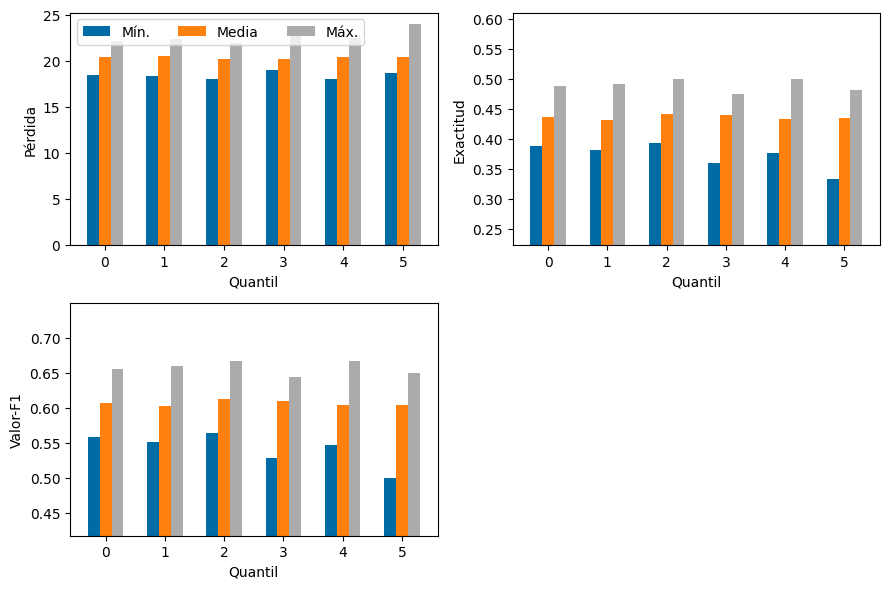

In [ ]:
#ticker_test_results = pd.read_parquet(f'{path}/ticker_test_results.parquet')
#ticker_market_cap = get_tickers_sorted_by_market_cap(tickers)
#ticker_test_results_by_quantile = get_test_results_by_quantile(ticker_test_results_for_threshold, ticker_market_cap, bins=6, autoencoder=False)
# np.percentile(ticker_market_cap['market_cap'], .99)

plot_test_results_by_quantile(ticker_test_results_by_quantile, ['loss', 'accuracy', 'f1_score'], limit_y=True, range_mult=3)

100%|██████████| 204/204 [00:11<00:00, 18.45it/s]


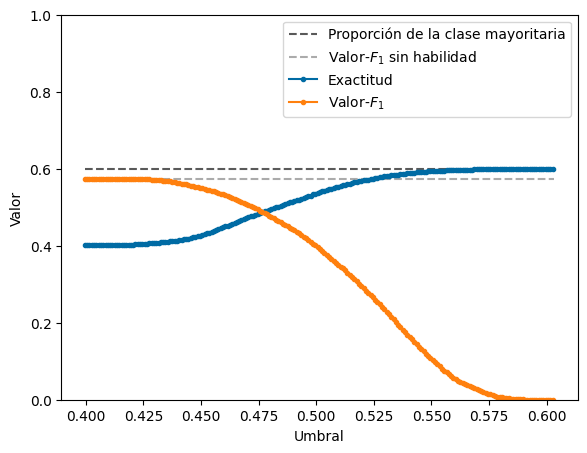

In [ ]:
#p = model.predict(D_val)
#best_threshold, thresholds = plot_prec_rec_curve(y, p, all_thresholds=False, path=path)
get_f1_acc_per_treshold(y, p, thresholds)

# [loss, accuracy, f1_score, precision, recall]
# get_test_results_for_threshold(D_test, y_test, best_threshold)

In [ ]:
dataset = D_val
p = model.predict(dataset)
y = np.concatenate([y for x, y in dataset], axis=0)
#y_test = np.concatenate([y for x, y in D_test], axis=0)
#y_train = np.concatenate([y for x, y in D_train], axis=0)

156/156 [==============================] - 135s 839ms/step


In [ ]:
'''
stat3 encoded bdt:
conv1d-stat3_conv1d-encoded_prov_dt_17200558400008375194
lstm-stat3_conv1d-encoded_prov_dt_17690321685868307719

stat3 bdt:
conv1d-stat3_final_dt_1442753706574165379
lstm-stat3_final_dt_1442753706574165379

stat3 encoded bfth:
conv1d-stat3_conv1d-encoded_prov_11031640322154569101
lstm-stat3_conv1d-encoded_final_11031640322154569101

stat3 bfth:
conv1d-stat3_final_1442753706574165379
lstm-stat3_final_17417155635726417589
'''

In [ ]:
model_name = 'lstm-stat3_conv1d-encoded_final_11031640322154569101'
path = f'/content/drive/MyDrive/final_models/stat3-prov/bfth/{model_name}'
model = load_model(f'{path}/{model_name}.keras')
model._name = 'model'

In [ ]:
ticker_test_results_for_threshold = get_ticker_test_results_for_threshold(D_test, 0.4092)

#res[res['f1_score']>.53]

#get_test_results_for_threshold(D_test, 0.429153)
#ticker_test_results_for_threshold[ticker_test_results_for_threshold['f1_score']>.53]

100%|██████████| 300/300 [04:43<00:00,  1.06it/s]


In [ ]:
ticker_test_results_for_threshold.sort_values('f1_score')

,loss,accuracy,f1_score,precision,recall
MCK,10.156631,0.718213,0.115108,0.372093,0.068085
NOC,11.023660,0.694158,0.118812,0.173077,0.090452
MSFT,11.230096,0.688431,0.122581,0.223529,0.084444
TT,12.840293,0.643757,0.123944,0.165414,0.099099
AMD,10.693363,0.703322,0.127946,0.271429,0.083700
...,...,...,...,...,...
J,12.055838,0.665521,0.273632,0.300546,0.251142
HOLX,11.808116,0.672394,0.274112,0.315789,0.242152
SHW,12.716432,0.647194,0.276995,0.297980,0.258772
CSCO,12.509997,0.652921,0.283688,0.292683,0.275229


In [ ]:
y_test = np.concatenate([y for x, y in D_test['IDXX']], axis=0)

In [ ]:
len([i for i in y_test if i==1]) / len(y_test)

0.2531500572737686

In [ ]:
ticker_test_results_by_quantile

,market_cap_min,market_cap_max,market_cap_mean,market_cap_count,loss_min,loss_max,loss_mean,accuracy_min,accuracy_max,accuracy_mean,f1_score_min,f1_score_max,f1_score_mean,precision_min,precision_max,precision_mean,recall_min,recall_max,recall_mean
quantile,,,,,,,,,,,,,,,,,,,
0,6.681722,14.722393,11.723552,50,18.454351,22.079312,20.337683,0.387429,0.488000,0.435749,0.558484,0.655914,0.606699,0.387429,0.488000,0.435759,0.997375,1.0,0.999948
1,15.158088,23.086398,18.765737,50,18.330772,22.326469,20.477738,0.380571,0.491429,0.431863,0.551325,0.659004,0.602819,0.380571,0.491429,0.431882,0.997067,1.0,0.999891
2,23.360947,41.211827,30.910591,50,18.042423,21.873349,20.128424,0.393143,0.499429,0.441554,0.564397,0.666159,0.612145,0.393143,0.499429,0.441521,0.997253,1.0,0.999890
3,41.524696,62.621263,50.883237,50,18.948663,23.109131,20.199275,0.358857,0.474286,0.439589,0.528175,0.643411,0.610360,0.358857,0.474286,0.439563,1.000000,1.0,1.000000
4,64.767437,130.111230,92.400173,50,18.042423,22.491240,20.432426,0.376000,0.499429,0.433120,0.546512,0.666159,0.603991,0.376000,0.499429,0.433116,0.997067,1.0,0.999941
5,130.211154,3185.329380,358.951357,50,18.701507,24.015371,20.405239,0.333714,0.481143,0.433874,0.500428,0.649691,0.604528,0.333714,0.481143,0.433885,0.997613,1.0,0.999952


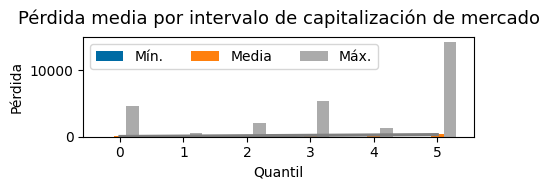

In [ ]:
plot_test_results_by_quantile(ticker_test_results_by_quantile, ['loss'], limit_y=True, range_mult=3)

In [ ]:
ticker_test_results[ticker_test_results['accuracy']>=0.62]

### Train history

In [ ]:
import json
train_loss = train_acc = train_f1 = train_prec = train_rec = val_loss = val_acc = val_f1 = val_prec = val_rec=  None

with open(f'{path}/train_history.json') as f:
    history = json.load(f)
    train_loss = history['train_loss']
    train_acc = history['train_acc']
    train_f1 = history['train_f1']
    train_precision = history['train_precision']
    train_recall = history['train_recall']
    val_loss = history['val_loss']
    val_acc = history['val_acc']
    val_f1 = history['val_f1']
    val_precision = history['val_precision']
    val_recall = history['val_recall']


In [ ]:
def plot_train_history(train_loss, val_loss, train_acc=None, val_acc=None, train_f1=None,
                       val_f1=None, train_precision=None, val_precision=None, train_recall=None,
                       val_recall=None, path=None, show=True, lang='Spanish'):
    plt.figure(figsize=(10, 2.5))
    plt.subplot(1, 3, 1)
    if (lang=='Spanish'):
        plt.plot(range(1, len(train_loss) + 1), train_loss, label='Entrenamiento')
        plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validación')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
    else:
        plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
        plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
    plt.legend()

    if train_acc is not None:
        plt.subplot(1, 3, 2)
        if (lang=='Spanish'):
            plt.plot(range(1, len(train_acc) + 1), train_acc, label='Entrenamiento')
            plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validación')
            plt.xlabel('Época')
            plt.ylabel('Exactitud')
        else:
            plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
            plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
        #plt.legend()

    if train_f1 is not None:
        plt.subplot(1, 3, 3)
        if (lang=='Spanish'):
            plt.plot(range(1, len(train_f1) + 1), train_f1, label='Entrenamiento')
            plt.plot(range(1, len(val_f1) + 1), val_f1, label='Validación')
            plt.xlabel('Época')
            plt.ylabel('Valor-F1')
        else:
            plt.plot(range(1, len(train_f1) + 1), train_f1, label='Training f1-score')
            plt.plot(range(1, len(val_f1) + 1), val_f1, label='Validation f1-score')
            plt.xlabel('Epochs')
            plt.ylabel('f1-score')
        # plt.legend()
        plt.tight_layout()

    if train_precision is not None:
        plt.subplot(2, 3, 4)
        if (lang=='Spanish'):
            plt.plot(range(1, len(train_precision) + 1), train_precision, label='Entrenamiento')
            plt.plot(range(1, len(val_precision) + 1), val_precision, label='Validación')
            plt.xlabel('Época')
            plt.ylabel('Precisión')
        else:
            plt.plot(range(1, len(train_precision) + 1), train_precision, label='Training precision')
            plt.plot(range(1, len(val_precision) + 1), val_precision, label='Validation precision')
            plt.xlabel('Epochs')
            plt.ylabel('Precision')
        plt.legend()
        plt.tight_layout()

    if train_recall is not None:
        plt.subplot(2, 3, 5)
        if (lang=='Spanish'):
            plt.plot(range(1, len(train_recall) + 1), train_recall, label='Entrenamiento')
            plt.plot(range(1, len(val_recall) + 1), val_recall, label='Validación')
            plt.xlabel('Época')
            plt.ylabel('Exhaustividad')
        else:
            plt.plot(range(1, len(train_recall) + 1), train_recall, label='Training recall')
            plt.plot(range(1, len(val_recall) + 1), val_recall, label='Validation recall')
            plt.xlabel('Epochs')
            plt.ylabel('Recall')
        plt.legend()
        plt.tight_layout()

    if path is not None:
        plt.savefig(path, format='svg')
    if show:
        plt.show()
    else:
        plt.close()

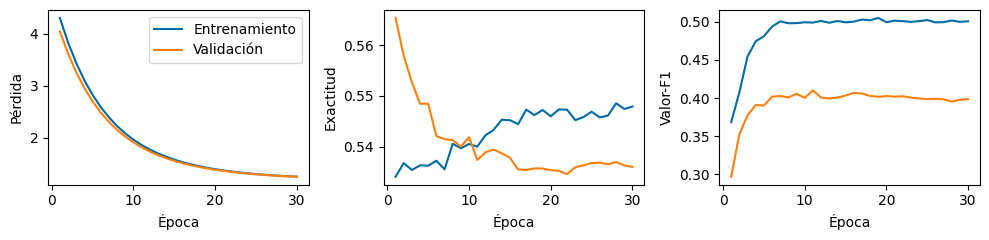

In [ ]:
n = len(train_loss)
train_history = {
                'train_loss':train_loss[:n],
                'val_loss':val_loss[:n],
                'train_acc':train_acc[:n],
                'val_acc':val_acc[:n],
                'train_f1':train_f1[:n],
                'val_f1':val_f1[:n],
            }

plot_train_history(path=f'{path}/train_history_2.svg', show=True, **train_history)

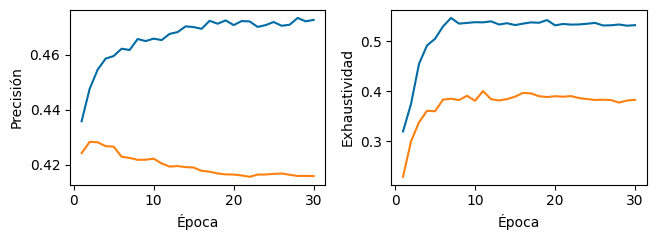

In [ ]:
plt.figure(figsize=(2*(10/3.), 2.5))
lang = 'Spanish'

plt.subplot(1, 2, 1)
if (lang=='Spanish'):
    plt.plot(range(1, len(train_precision) + 1), train_precision, label='Entrenamiento')
    plt.plot(range(1, len(val_precision) + 1), val_precision, label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
else:
    plt.plot(range(1, len(train_precision) + 1), train_precision, label='Training precision')
    plt.plot(range(1, len(val_precision) + 1), val_precision, label='Validation precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
plt.tight_layout()

plt.subplot(1, 2, 2)
if (lang=='Spanish'):
    plt.plot(range(1, len(train_recall) + 1), train_recall, label='Entrenamiento')
    plt.plot(range(1, len(val_recall) + 1), val_recall, label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Exhaustividad')
else:
    plt.plot(range(1, len(train_recall) + 1), train_recall, label='Training recall')
    plt.plot(range(1, len(val_recall) + 1), val_recall, label='Validation recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
plt.tight_layout()

plt.savefig(f'{path}/train_history_3.svg', format='svg')